In [2]:
!pip install alpaca-trade-api
!pip install python-dotenv
import pandas as pd
import numpy as np
import alpaca_trade_api as tradeapi
from datetime import datetime, timedelta
import os
import time
from datetime import timezone
import matplotlib.pyplot as plt
from dotenv import load_dotenv

In [3]:

load_dotenv()

# Fetch environment variables
API_KEY = os.getenv("APCA_API_KEY_ID")
SECRET_KEY = os.getenv("APCA_API_SECRET_KEY")
BASE_URL = os.getenv("APCA_API_BASE_URL")

# Raise error if any variable is missing
if not API_KEY or not SECRET_KEY or not BASE_URL:
    raise ValueError("Missing Alpaca API credentials. Please check your .env file.")

api = tradeapi.REST(
    API_KEY,
    SECRET_KEY,
    BASE_URL,
    api_version='v2'
)

In [4]:
# === Strategy Parameters ===
# === Strategy Parameters ===
symbols = ['BTC/USD', 'ETH/USD', 'XRP/USD']
ema_fast_period = 10
ema_slow_period = 26
sma_period = 50
max_drawdown = 0.20
price_buffer = 1.002  

total_capital = 80000
capital_per_asset = total_capital / len(symbols)


In [5]:

# === Helper Functions ===

def fetch_data(symbol, lookback_days=5):
    now = datetime.now(timezone.utc)
    start = now - timedelta(days=lookback_days)
    bars = api.get_crypto_bars(symbol, timeframe='1H', start=start.isoformat(), end=now.isoformat()).df

    if bars.empty:
        print(f"[{symbol}] No data returned.")
        return pd.DataFrame()

    # Ensure timestamp exists
    if 'timestamp' in bars.columns:
        bars.set_index('timestamp', inplace=True)
    else:
        bars.index.name = 'timestamp'

    bars = bars[bars['symbol'] == symbol].copy()
    bars.sort_index(inplace=True)
    return bars

def generate_signals(close):
    ema_fast = close.ewm(span=ema_fast_period).mean()
    ema_slow = close.ewm(span=ema_slow_period).mean()
    sma = close.rolling(sma_period).mean()

    ema_cross_up = ema_fast > ema_slow
    ema_cross_down = ema_fast < ema_slow
    trend_bull = close > sma
    trend_bear = close < sma
    price_above_buffer = close > ema_slow * price_buffer

    entries = ema_cross_up & trend_bull & price_above_buffer
    exits = ema_cross_down & trend_bear

    return entries, exits, ema_fast, ema_slow, sma

def in_position(symbol):
    positions = api.list_positions()
    asset = symbol.replace('/', '').upper()
    for p in positions:
        if p.symbol.upper() == asset:
            return True
    return False

def log_equity():
    account = api.get_account()
    now = datetime.now(timezone.utc)
    equity = float(account.equity)
    df = pd.DataFrame([[now, equity]], columns=["timestamp", "equity"])
    os.makedirs('trade_logs', exist_ok=True)
    filepath = 'trade_logs/portfolio_equity.csv'
    df.to_csv(filepath, mode='a', header=not os.path.exists(filepath), index=False)

In [6]:
# === Main Trading Logic ===

def run_trader():
    for symbol in symbols:
        try:
            print(f"\n--- Running strategy for {symbol} ---")
            df = fetch_data(symbol)

            if df.empty or len(df) < sma_period:
                print(f"[{symbol}] Not enough data, skipping.")
                continue

            if 'close' not in df.columns:
                print(f"[{symbol}] Missing 'close' data, skipping.")
                continue

            close = df['close']
            entries, exits, ema_fast, ema_slow, sma = generate_signals(close)

            # Debug print to understand signal conditions
            print(f"[{symbol}] Last Close: {close.iloc[-1]:.2f}")
            print(f"[{symbol}] EMA Fast: {ema_fast.iloc[-1]:.2f}, EMA Slow: {ema_slow.iloc[-1]:.2f}, SMA: {sma.iloc[-1]:.2f}")
            print(f"[{symbol}] Entry: {entries.iloc[-1]}, Exit: {exits.iloc[-1]}")

            latest_entry = entries.iloc[-1]
            latest_exit = exits.iloc[-1]

            is_in = in_position(symbol)
            latest_price = close.iloc[-1]
            asset = symbol.replace('/', '').upper()
            trade_qty = round(capital_per_asset / latest_price, 6)

            # Entry
            if latest_entry and not is_in:
                print(f"[{symbol}] ENTRY signal — Buying {trade_qty} {asset} at approx {latest_price:.2f}")
                api.submit_order(
                    symbol=asset,
                    qty=trade_qty,
                    side='buy',
                    type='market',
                    time_in_force='gtc'
                )
            # Exit
            elif latest_exit and is_in:
                position = api.get_position(asset)
                qty_to_sell = float(position.qty)

                print(f"[{symbol}] EXIT signal — Selling {qty_to_sell} {asset} at approx {latest_price:.2f}")
                api.submit_order(
                    symbol=asset,
                    qty=qty_to_sell,
                    side='sell',
                    type='market',
                    time_in_force='gtc'
                )
            else:
                print(f"[{symbol}] No trade action today.")

        except Exception as e:
            print(f"Error processing {symbol}: {e}")
            continue

    log_equity()
    print("✅ Equity logged.")

    # === Run ===
if __name__ == "__main__":
    run_trader()



--- Running strategy for BTC/USD ---
[BTC/USD] Last Close: 118573.62
[BTC/USD] EMA Fast: 118438.12, EMA Slow: 118177.42, SMA: 118006.12
[BTC/USD] Entry: True, Exit: False
[BTC/USD] No trade action today.

--- Running strategy for ETH/USD ---
[ETH/USD] Last Close: 3858.45
[ETH/USD] EMA Fast: 3852.70, EMA Slow: 3829.19, SMA: 3807.38
[ETH/USD] Entry: True, Exit: False
[ETH/USD] No trade action today.

--- Running strategy for XRP/USD ---
[XRP/USD] Last Close: 3.17
[XRP/USD] EMA Fast: 3.15, EMA Slow: 3.13, SMA: 3.12
[XRP/USD] Entry: True, Exit: False
[XRP/USD] No trade action today.
✅ Equity logged.


In [7]:
# Get historical account equity (change '1D' and 600 days)
df = api.get_portfolio_history(period='30D', timeframe='1D').df

# Clean data
df = df.reset_index()
df['equity'] = df['equity'].astype(float)


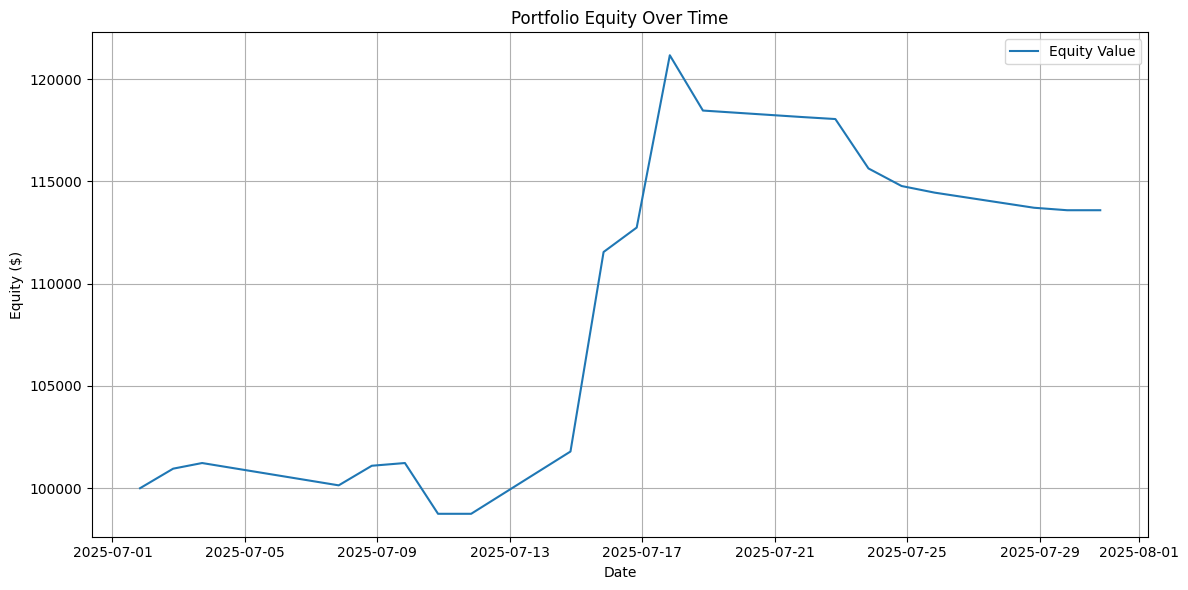

In [8]:

plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['equity'], label='Equity Value')
plt.title('Portfolio Equity Over Time')
plt.xlabel('Date')
plt.ylabel('Equity ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:

import plotly.express as px

fig = px.line(df, x='timestamp', y='equity', title='Portfolio Equity Over Time')
fig.update_layout(xaxis_title='Date', yaxis_title='Equity ($)')
fig.show()


In [10]:
# Convert notebook to script
try:
    # Check if running in a Jupyter notebook
    shell = get_ipython().__class__.__name__
    if shell == 'ZMQInteractiveShell':
        import os
        os.system('jupyter nbconvert stratagy_alpaca_trading.ipynb --to script')
except NameError:
    pass

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'stratagy_alpaca_trading.ipynb' matched no files
